# **Transforming US Airline Tweets Feedback for Enhanced Customer Feedback Management**

# **Importing the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
nltk.download(["stopwords","punkt","wordnet","omw-1.4","vader_lexicon"])
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# **Exploratory Data Analysis (EDA)**

In [2]:
#Importing and reading the CSV file 'Tweets.csv' into a DataFrame named 'df'
df = pd.read_csv("Tweets.csv")

# Create independent copies
df_classification = df.copy()  # For classification
df_sentiment = df.copy()  # For sentiment analysis

# Displaying the first five rows of the DataFrame
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
# Display basic statistics of numeric cloumns of the dataset.
df.describe(include="all")

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,1.464000e+04,14640,14640.000000,9178,10522.000000,14640,40,14640,32,14640.000000,14640,1019,14640,9907,9820
unique,NaN,3,NaN,10,NaN,6,3,7701,13,NaN,14427,832,14247,3081,85
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9178,NaN,2910,NaN,3822,32,63,12,NaN,6,164,5,157,3744
mean,5.692184e+17,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,NaN,NaN
std,7.791112e+14,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,NaN,NaN
min,5.675883e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5.685592e+17,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
50%,5.694779e+17,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
75%,5.698905e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


In [5]:
# Checking the number of missing values in 'airline_sentiment', 'text' columns.
df[['airline_sentiment', 'text']].isnull().sum()

,0
airline_sentiment,0
text,0


In [6]:
# Counting the occurrences of each unique value in the 'airline_sentiment' column.
df["airline_sentiment"].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [7]:
# Displaying the first five rows of the 'text' column to inspect the content of the tweets
df["text"].head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


In [8]:
# Filtering the DataFrame to exclude rows where the 'airline_sentiment' is 'neutral'
df_classification = df_classification[df_classification['airline_sentiment'] != 'neutral']
df_classification["airline_sentiment"].value_counts()

,count
airline_sentiment,
negative,9178
positive,2363


<Axes: xlabel='airline_sentiment', ylabel='count'>

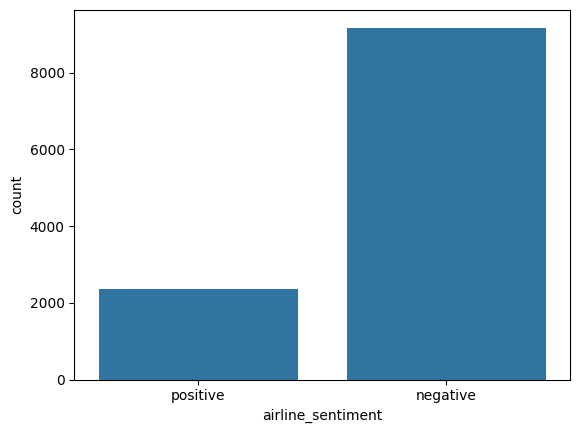

In [9]:
# Creating a count plot to visualize the distribution of 'airline_sentiment' after filtering
sns.countplot(x="airline_sentiment",data=df_classification)

# **Data Cleaning and Preprocessing**

In [10]:
# Importing the list of English stopwords from the NLTK library
stop_words = nltk.corpus.stopwords.words("english")

additional_stopwords = ["americanair", "flight", "get", "call", "aa", "hour", "service", "custom","2", "cancel", "would", "http", "time"]
stop_words.extend(additional_stopwords)


print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
# Defining a function to preprocess text by:
# - Tokenizing the text using a regular expression to keep only alphanumeric words and apostrophes
# - Converting tokens to lowercase and removing common stopwords (e.g., 'the', 'and')
# - Applying stemming to reduce words to their root form (e.g., "running" -> "run")
def preprocess_text(text):
  tokenizer = nltk.tokenize.RegexpTokenizer("[a-zA-Z0-9\']+").tokenize(text)
  tokenizer = [word for word in tokenizer if len(word) >= 3]
  cleaned_tokens = [word.lower() for word in tokenizer if word.lower() not in stop_words]
  stemmed_text = [nltk.stem.PorterStemmer().stem(word) for word in cleaned_tokens]
  return stemmed_text

In [12]:
# Updating the 'text' Column in the DataFrame This involves tokenization, stopword removal, and stemming of each tweet
df_classification["text"] = df_classification["text"].apply(preprocess_text)
df_classification.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,"[virginamerica, plu, ad, commerci, experi, tacki]",NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"[virginamerica, realli, aggress, blast, obnoxi...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,"[virginamerica, realli, big, bad, thing]",NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,"[virginamerica, serious, pay, seat, play, real...",NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"[virginamerica, ye, nearli, everi, fli, ear, w...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)


In [13]:
# Term Frequency Matrix
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_classification["text"].map(''.join))
X = pd.DataFrame(X.toarray())
X.head()

,0,1,2,3,4,5,6,7,8,9,...,13192,13193,13194,13195,13196,13197,13198,13199,13200,13201
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Model Training and Evaluation**

### **Splitting Data into Training and Testing Sets**

In [14]:
#Splitting Data into Training and Testing Sets for Model Evaluation
from sklearn.model_selection import train_test_split

y = df_classification["airline_sentiment"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)

### **Handling Imbalanced**

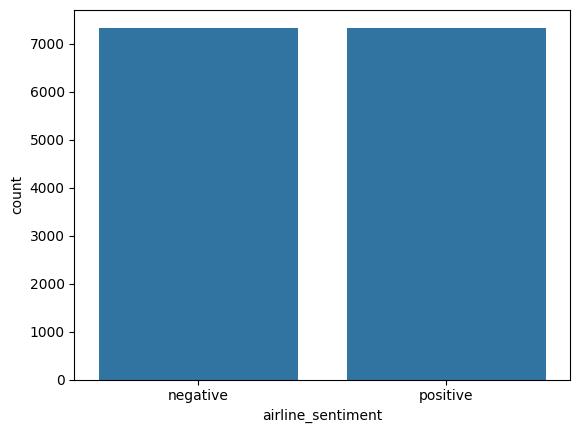

In [15]:
  from imblearn.over_sampling import SMOTE
  resampler= SMOTE(random_state=0)
  X_train_oversampled,y_train_oversampled=resampler.fit_resample(X_train,y_train)
  sns.countplot(x=y_train_oversampled)
  plt.show()

### **Training the Model**

In [16]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train,y_train)

MultinomialNB()

### **Model Evaluation**

In [17]:
y_pred = model.predict(X_test)

from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred)
print("K-NN Accuracy:",acc)
print("----------------------------------------------------")
# Compute and print the confusion matrix to evaluate the performance of the classification model
cm = metrics.confusion_matrix(y_test, y_pred)
print(f"K-NN Confusion Matrix:\n{cm}")
print("----------------------------------------------------")
# Print the classification report to evaluate model performance.
report = metrics.classification_report(y_test, y_pred)
print(f"K-NN Classification Report:\n {report}")

K-NN Accuracy: 0.8059766132524903
----------------------------------------------------
K-NN Confusion Matrix:
[[1833    3]
 [ 445   28]]
----------------------------------------------------
K-NN Classification Report:
               precision    recall  f1-score   support

    negative       0.80      1.00      0.89      1836
    positive       0.90      0.06      0.11       473

    accuracy                           0.81      2309
   macro avg       0.85      0.53      0.50      2309
weighted avg       0.82      0.81      0.73      2309



# **Sentiment Analysis**

### **Initializing the Sentiment Analyzer and Calculating Sentiment Scores**

In [18]:
# Initializing the SentimentIntensityAnalyzer
sentimentor = SentimentIntensityAnalyzer()

# Creating new columns in the DataFrame to store sentiment scores for each tweet.
df_sentiment["compound"] = [sentimentor.polarity_scores(tweet)["compound"] for tweet in df_sentiment["text"]]
df_sentiment["neg"] = [sentimentor.polarity_scores(tweet)["neg"] for tweet in df_sentiment["text"]]
df_sentiment["neu"] = [sentimentor.polarity_scores(tweet)["neu"] for tweet in df_sentiment["text"]]
df_sentiment["pos"] = [sentimentor.polarity_scores(tweet)["pos"] for tweet in df_sentiment["text"]]

### **Exploratory Analysis of Sentiment Scores**

In [19]:
# Displaying the first five rows of the updated DataFrame to inspect the newly added sentiment score columns
df_sentiment.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,compound,neg,neu,pos
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0.0000,0.000,1.000,0.0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0.0000,0.000,1.000,0.0
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0.0000,0.000,1.000,0.0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),-0.5984,0.246,0.754,0.0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),-0.5829,0.321,0.679,0.0


In [20]:
# Generating summary statistics to understand the distribution of sentiment scores in the dataset
df_sentiment[["compound","neg","neu","pos"]].describe()

,compound,neg,neu,pos
count,14640.000000,14640.000000,14640.000000,14640.000000
mean,0.052463,0.083950,0.794055,0.121991
std,0.456935,0.111314,0.166833,0.160114
min,-0.966800,0.000000,0.102000,0.000000
25%,-0.296000,0.000000,0.693000,0.000000
50%,0.000000,0.000000,0.808000,0.069000
75%,0.438225,0.147000,0.917000,0.198000
max,0.976000,0.857000,1.000000,0.898000


<Axes: xlabel='compound', ylabel='Count'>

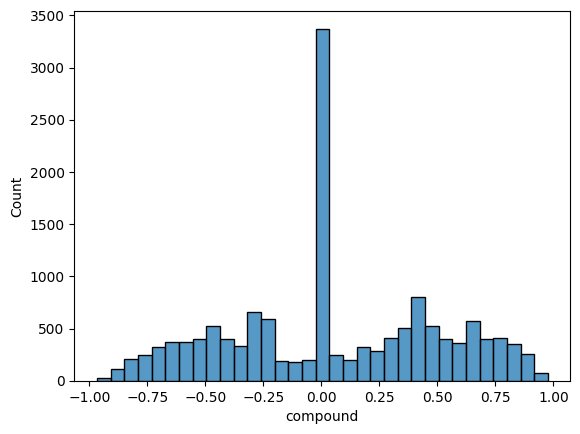

In [21]:
# Creating a histogram to visualize the distribution of the 'compound' sentiment scores
sns.histplot(df_sentiment["compound"])

<Axes: xlabel='pos', ylabel='Count'>

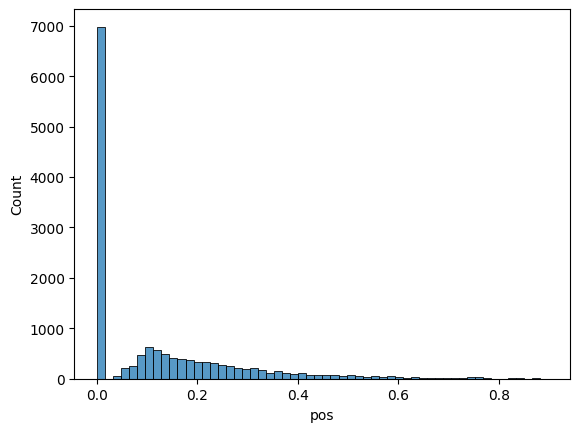

In [22]:
# Creating a histogram to visualize the distribution of the 'positive' sentiment scores
sns.histplot(df_sentiment["pos"])

<Axes: xlabel='neg', ylabel='Count'>

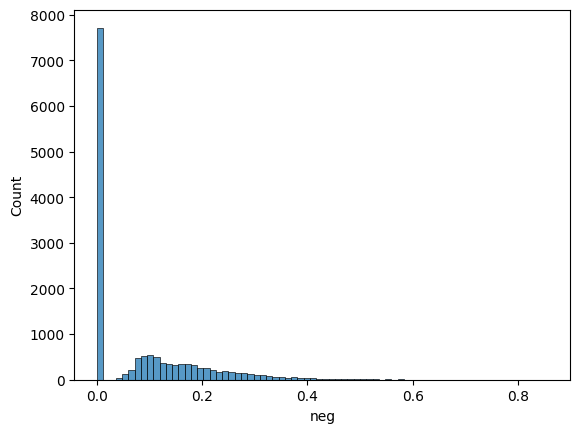

In [23]:
# Creating a histogram to visualize the distribution of the 'negative' sentiment scores
sns.histplot(df_sentiment["neg"])

In [24]:
#Counting Non-Positive Sentiment Tweets Grouped by Airline
(df_sentiment["compound"]<=0).groupby(df_sentiment["airline"]).sum()

,compound
airline,
American,1638
Delta,1222
Southwest,1230
US Airways,1828
United,2227
Virgin America,276


In [25]:
# Calculating the percentage of negative tweets for each airline.
percent_negative = pd.DataFrame((df_sentiment["compound"]<=0).groupby(df_sentiment["airline"]).sum()
                                /df_sentiment["airline"].groupby(df_sentiment["airline"]).count()*100,
                                columns=["% negative tweets"]).sort_values(by= "% negative tweets")

percent_negative["% negative tweets"] = percent_negative["% negative tweets"].round(2)

percent_negative

,% negative tweets
airline,
Southwest,50.83
Virgin America,54.76
Delta,55.00
United,58.27
American,59.37
US Airways,62.75


Text(0.5, 1.0, 'Percentage of Negative Tweets by Airline')

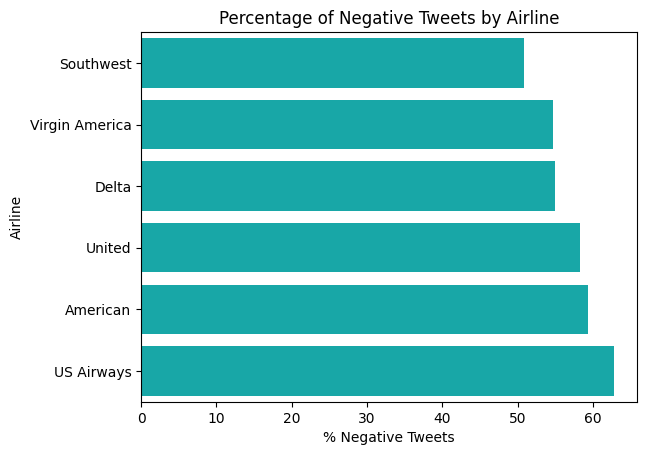

In [26]:
# Visualizing the Percentage of Negative Tweets by Airline
sns.barplot(data = percent_negative, x ="% negative tweets", y= percent_negative.index , color = "c")
plt.xlabel("% Negative Tweets")
plt.ylabel("Airline")
plt.title("Percentage of Negative Tweets by Airline")

In [27]:
# Preprocessing Tweets and Filtering Positive/Negative Subsets for American Airlines

df_sentiment['processed_tweet'] = df_sentiment['text'].apply(preprocess_text)

tweets_positive_subset = df_sentiment.loc[(df_sentiment['airline'] == 'American') & (df_sentiment['compound'] > 0),:]

tweets_negative_subset = df_sentiment.loc[(df_sentiment['airline'] == 'American') & (df_sentiment['compound'] <= 0),:]

tweets_positive_subset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,compound,neg,neu,pos,processed_tweet
11881,570307949614256128,negative,0.6316,Bad Flight,0.3164,American,NaN,ELLLORRAC,NaN,0,@AmericanAir thanks for getting back to me. Bu...,NaN,2015-02-24 11:43:05 -0800,NaN,Central Time (US & Canada),0.2382,0.000,0.878,0.122,"[thank, get, back, find, airlin, futur]"
11882,570307948171423745,negative,0.6846,Flight Booking Problems,0.6846,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I pay $200 to reactivat...,NaN,2015-02-24 11:43:05 -0800,NaN,Quito,0.4468,0.122,0.678,0.199,"[pay, 200, reactiv, point, use, certain, fligh..."
11883,570307434113310720,negative,0.6547,Late Flight,0.3331,American,NaN,LauraMolito,NaN,0,"@AmericanAir stranded for 24 hours in MIA, Pat...",NaN,2015-02-24 11:41:02 -0800,"New York, NY",Atlantic Time (Canada),0.0173,0.188,0.622,0.190,"[strand, hour, mia, patrick, casimir, staff, a..."
11890,570306529947193344,negative,0.6449,longlines,0.3340,American,NaN,TheTPVshow,NaN,0,@AmericanAir I slept in the miami airport due ...,NaN,2015-02-24 11:37:27 -0800,MN,Central Time (US & Canada),0.5423,0.000,0.863,0.137,"[slept, miami, airport, due, mechan, issu, giv..."
11891,570306423818723328,neutral,0.6767,NaN,0.0000,American,NaN,sammy575,NaN,0,@AmericanAir is the new 9:45 time confirmed or...,NaN,2015-02-24 11:37:01 -0800,New York,Eastern Time (US & Canada),0.3818,0.081,0.732,0.187,"[new, confirm, may, cancel, flightl, travel, k..."


### **Visualizing Word Clouds for Sentiment Subsets**

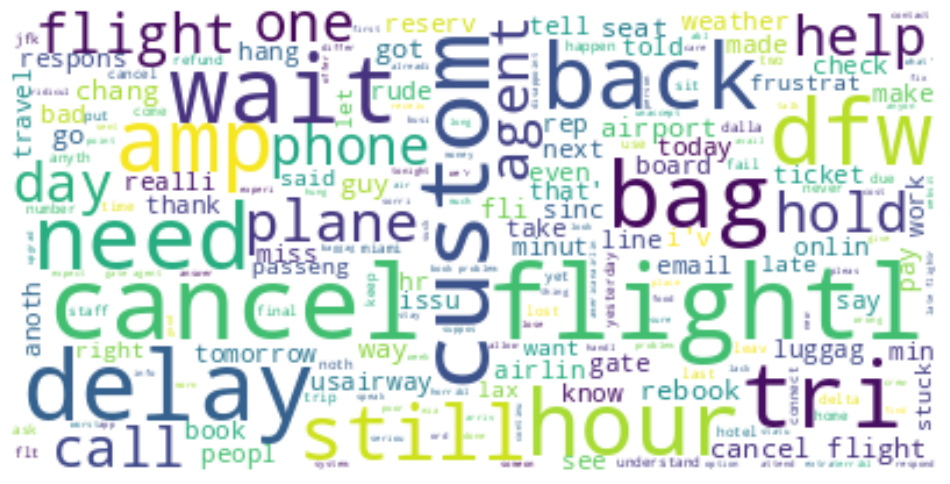

In [28]:
# Displaying a Word Cloud for Negative Tweets

neg_tokens = [word for tweet in tweets_negative_subset['processed_tweet'] for word in tweet]

wordcloud = WordCloud(background_color='white').generate_from_text(" ".join(neg_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

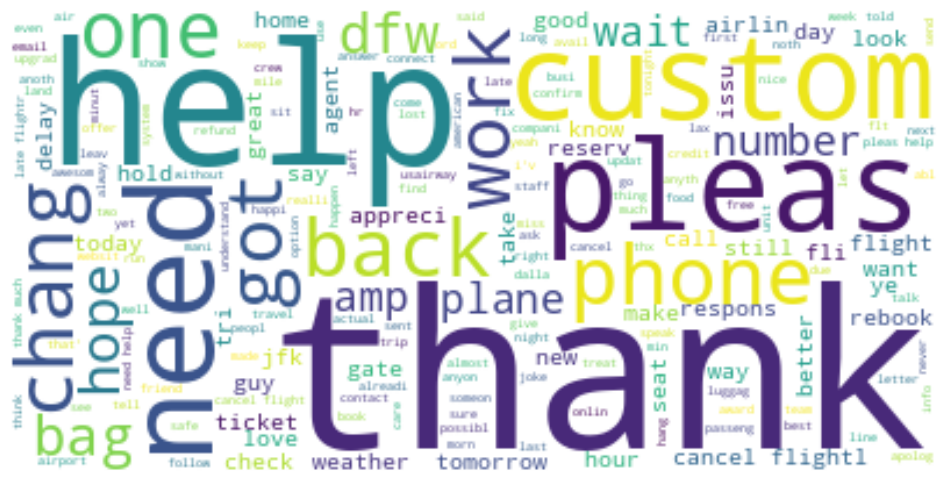

In [29]:
# Displaying a Word Cloud for Positive Tweets

pos_tokens = [word for tweet in tweets_positive_subset['processed_tweet'] for word in tweet]

wordcloud = WordCloud(background_color='white').generate_from_text(" ".join(pos_tokens))

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Frequency Distribution of Sentiment Tokens**

In [30]:
# Tabulating the Frequency Distribution of Positive Tweet Tokens

from nltk.probability import FreqDist

pos_freqdist = FreqDist(pos_tokens)

pos_freqdist.tabulate(10)

 thank   help  pleas cancel   need custom  can't   like    i'm  chang 
   284    186     93     90     74     67     66     64     57     55 


In [31]:
# Tabulating the Frequency Distribution of Negative Tweet Tokens

from nltk.probability import FreqDist

pos_freqdist = FreqDist(neg_tokens)

pos_freqdist.tabulate(10)

 cancel  custom  flight    wait flightl    hour   delay     tri   still    hold 
    237     135     132     132     125     125     109     101      96      94 
